In [ ]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
zip_file = keras.utils.get_file(
    fname="cora.tgz",
    origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",
    extract=True,
)
data_dir = os.path.join(os.path.dirname(zip_file), "cora")

168052/168052 [==============================] - 0s 0us/step


### Process and visualize the dataset

Then we load the citations data into a Pandas DataFrame.

In [ ]:
citations = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)
print("Citations shape:", citations.shape)

Citations shape: (5429, 2)


In [ ]:
citations.sample(frac=1).head()

,target,source
5048,578845,578645
2376,22566,10435
5099,594039,1129015
2286,20584,389715
3102,42221,57948


In [ ]:
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]
papers = pd.read_csv(
    os.path.join(data_dir, "cora.content"), sep="\t", header=None, names=column_names,
)
print("Papers shape:", papers.shape)

Papers shape: (2708, 1435)


In [ ]:
print(papers.sample(5).T)

                      2631                1826             1200    1863  \
paper_id            430574              509315          1132948  107252   
term_0                   0                   0                0       0   
term_1                   0                   0                0       0   
term_2                   0                   0                0       0   
term_3                   0                   0                0       0   
...                    ...                 ...              ...     ...   
term_1429                0                   0                0       0   
term_1430                0                   0                0       0   
term_1431                0                   0                0       0   
term_1432                0                   0                1       0   
subject    Neural_Networks  Genetic_Algorithms  Neural_Networks  Theory   

                             1599  
paper_id                  1104182  
term_0                     

In [ ]:
print(papers.subject.value_counts())

Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: subject, dtype: int64


In [ ]:
class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

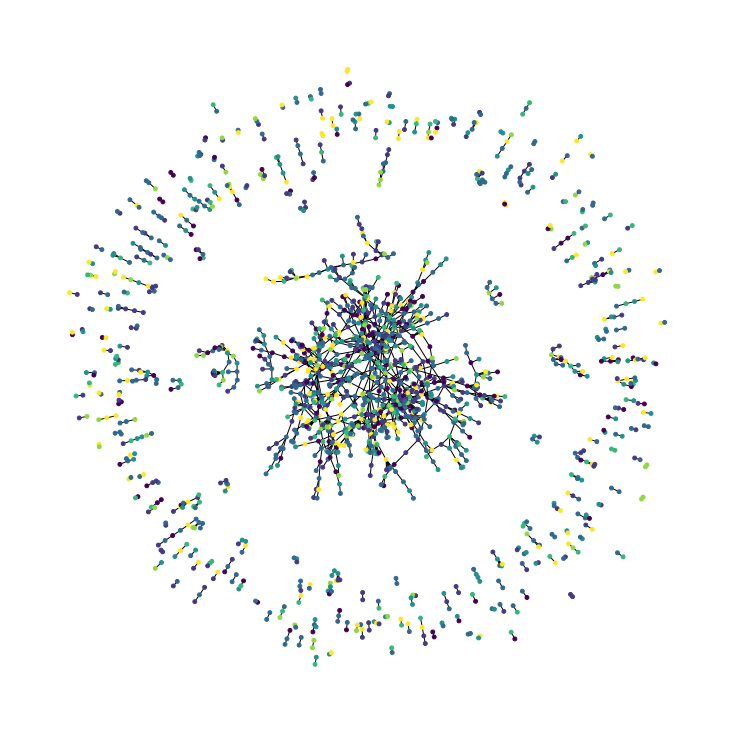

In [ ]:
plt.figure(figsize=(10, 10))
colors = papers["subject"].tolist()
cora_graph = nx.from_pandas_edgelist(citations.sample(n=1500))
subjects = list(papers[papers["paper_id"].isin(list(cora_graph.nodes))]["subject"])
nx.draw_spring(cora_graph, node_size=15, node_color=subjects)


In [ ]:
train_data, test_data = [], []

for _, group_data in papers.groupby("subject"):
    # Select around 50% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.5
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (1373, 1435)
Test data shape: (1335, 1435)


## Implement Train and Evaluate Experiment

In [ ]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

In [ ]:

def run_experiment(model, x_train, y_train):
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history


In [ ]:

def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()


In [ ]:

def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)


In [ ]:
feature_names = set(papers.columns) - {"paper_id", "subject"}
num_features = len(feature_names)
num_classes = len(class_idx)

x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
y_train = train_data["subject"]
y_test = test_data["subject"]

In [ ]:

def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    logits = layers.Dense(num_classes, name="logits")(x)
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")


baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate)
baseline_model.summary()

Model: "baseline"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_features (InputLayer)    [(None, 1433)]       0           []                               
                                                                                                  
 ffn_block1 (Sequential)        (None, 32)           52804       ['input_features[0][0]']         
                                                                                                  
 ffn_block2 (Sequential)        (None, 32)           2368        ['ffn_block1[0][0]']             
                                                                                                  
 skip_connection2 (Add)         (None, 32)           0           ['ffn_block1[0][0]',             
                                                                  'ffn_block2[0][0]']      

### Train the baseline classifier

In [ ]:
history = run_experiment(baseline_model, x_train, y_train)

Epoch 1/300
5/5 [==============================] - 3s 94ms/step - loss: 3.7234 - acc: 0.1431 - val_loss: 1.9121 - val_acc: 0.2718
Epoch 2/300
5/5 [==============================] - 0s 16ms/step - loss: 2.8510 - acc: 0.2511 - val_loss: 1.8913 - val_acc: 0.2816
Epoch 3/300
5/5 [==============================] - 0s 17ms/step - loss: 2.4392 - acc: 0.2391 - val_loss: 1.8905 - val_acc: 0.3058
Epoch 4/300
5/5 [==============================] - 0s 23ms/step - loss: 2.1977 - acc: 0.2356 - val_loss: 1.8952 - val_acc: 0.2816
Epoch 5/300
5/5 [==============================] - 0s 15ms/step - loss: 2.0510 - acc: 0.2802 - val_loss: 1.8880 - val_acc: 0.3058
Epoch 6/300
5/5 [==============================] - 0s 16ms/step - loss: 1.9654 - acc: 0.3085 - val_loss: 1.8652 - val_acc: 0.3155
Epoch 7/300
5/5 [==============================] - 0s 24ms/step - loss: 1.8061 - acc: 0.3385 - val_loss: 1.8247 - val_acc: 0.3592
Epoch 8/300
5/5 [==============================] - 0s 20ms/step - loss: 1.7338 - acc: 0.35

Let's plot the learning curves.

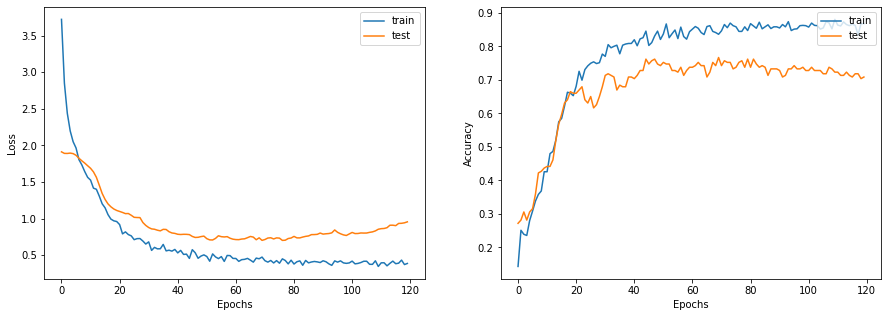

In [ ]:
display_learning_curves(history)

Now we evaluate the baseline model on the test data split.

In [ ]:
_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 75.13%


In [ ]:

def generate_random_instances(num_instances):
    token_probability = x_train.mean(axis=0)
    instances = []
    for _ in range(num_instances):
        probabilities = np.random.uniform(size=len(token_probability))
        instance = (probabilities <= token_probability).astype(int)
        instances.append(instance)

    return np.array(instances)


def display_class_probabilities(probabilities):
    for instance_idx, probs in enumerate(probabilities):
        print(f"Instance {instance_idx + 1}:")
        for class_idx, prob in enumerate(probs):
            print(f"- {class_values[class_idx]}: {round(prob * 100, 2)}%")


In [ ]:
new_instances = generate_random_instances(num_classes)
logits = baseline_model.predict(new_instances)
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

1/1 [==============================] - 0s 255ms/step
Instance 1:
- Case_Based: 9.16%
- Genetic_Algorithms: 26.57%
- Neural_Networks: 7.03%
- Probabilistic_Methods: 11.78%
- Reinforcement_Learning: 5.69%
- Rule_Learning: 18.35%
- Theory: 21.42%
Instance 2:
- Case_Based: 0.53%
- Genetic_Algorithms: 26.31%
- Neural_Networks: 12.49%
- Probabilistic_Methods: 55.12%
- Reinforcement_Learning: 3.6%
- Rule_Learning: 0.89%
- Theory: 1.06%
Instance 3:
- Case_Based: 7.74%
- Genetic_Algorithms: 4.31%
- Neural_Networks: 71.36%
- Probabilistic_Methods: 0.84%
- Reinforcement_Learning: 8.69%
- Rule_Learning: 4.4%
- Theory: 2.68%
Instance 4:
- Case_Based: 2.0%
- Genetic_Algorithms: 3.66%
- Neural_Networks: 75.3%
- Probabilistic_Methods: 6.76%
- Reinforcement_Learning: 7.25%
- Rule_Learning: 2.28%
- Theory: 2.76%
Instance 5:
- Case_Based: 46.31%
- Genetic_Algorithms: 6.31%
- Neural_Networks: 36.88%
- Probabilistic_Methods: 5.45%
- Reinforcement_Learning: 0.34%
- Rule_Learning: 0.42%
- Theory: 4.29%
Insta

In [ ]:
edges = citations[["source", "target"]].to_numpy().T
edge_weights = tf.ones(shape=edges.shape[1])
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 5429)
Nodes shape: (2708, 1433)


In [ ]:

class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super(GraphConvLayer, self).__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages, node_repesentations):
        num_nodes = node_repesentations.shape[0]
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        
        if self.combination_type == "gru":
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        

        node_repesentations, edges, edge_weights = inputs
        node_indices, neighbour_indices = edges[0], edges[1]
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        aggregated_messages = self.aggregate(
            node_indices, neighbour_messages, node_repesentations
        )
        return self.update(node_repesentations, aggregated_messages)


In [ ]:

class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super(GNNNodeClassifier, self).__init__(*args, **kwargs)

        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        x = self.preprocess(self.node_features)
        x1 = self.conv1((x, self.edges, self.edge_weights))
        x = x1 + x
        x2 = self.conv2((x, self.edges, self.edge_weights))
        x = x2 + x
        x = self.postprocess(x)
        node_embeddings = tf.gather(x, input_node_indices)
        return self.compute_logits(node_embeddings)


In [ ]:
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

print("GNN output shape:", gnn_model([1, 10, 100]))

gnn_model.summary()

GNN output shape: tf.Tensor(
[[ 0.08331486  0.14663911 -0.00339345  0.04576905  0.20219079  0.0834163
   0.13095573]
 [ 0.08226909  0.01181637  0.03820954  0.06066658  0.15431449  0.12577587
   0.14875647]
 [ 0.0885639  -0.04684339  0.04792869  0.04163823 -0.01158193  0.0847792
   0.04929645]], shape=(3, 7), dtype=float32)
Model: "gnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess (Sequential)     (2708, 32)                52804     
                                                                 
 graph_conv1 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                                 
 graph_conv2 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                              

In [ ]:
x_train = train_data.paper_id.to_numpy()
history = run_experiment(gnn_model, x_train, y_train)

Epoch 1/300
5/5 [==============================] - 4s 205ms/step - loss: 2.2791 - acc: 0.1654 - val_loss: 1.9169 - val_acc: 0.2573
Epoch 2/300
5/5 [==============================] - 1s 102ms/step - loss: 2.0051 - acc: 0.2476 - val_loss: 1.8971 - val_acc: 0.2718
Epoch 3/300
5/5 [==============================] - 1s 100ms/step - loss: 1.9566 - acc: 0.2622 - val_loss: 1.8887 - val_acc: 0.2718
Epoch 4/300
5/5 [==============================] - 1s 104ms/step - loss: 1.9243 - acc: 0.2588 - val_loss: 1.8846 - val_acc: 0.2718
Epoch 5/300
5/5 [==============================] - 0s 101ms/step - loss: 1.8859 - acc: 0.2793 - val_loss: 1.8786 - val_acc: 0.2718
Epoch 6/300
5/5 [==============================] - 1s 104ms/step - loss: 1.8484 - acc: 0.2828 - val_loss: 1.8710 - val_acc: 0.2718
Epoch 7/300
5/5 [==============================] - 1s 106ms/step - loss: 1.8487 - acc: 0.2956 - val_loss: 1.8569 - val_acc: 0.2718
Epoch 8/300
5/5 [==============================] - 0s 101ms/step - loss: 1.8173 - a

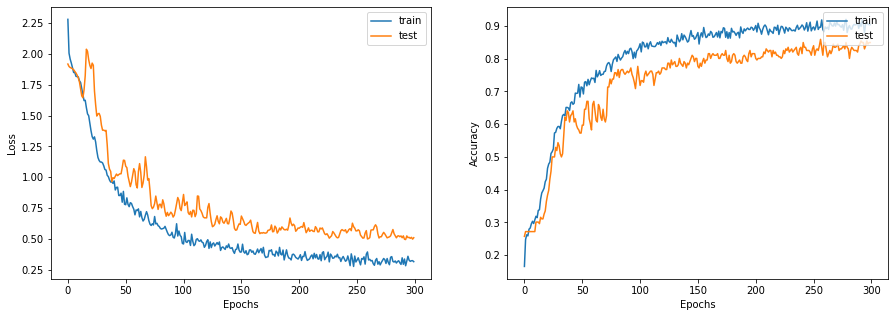

In [ ]:
display_learning_curves(history)

In [ ]:
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 83.15%


In [ ]:

num_nodes = node_features.shape[0]
new_node_features = np.concatenate([node_features, new_instances])

new_node_indices = [i + num_nodes for i in range(num_classes)]
new_citations = []
for subject_idx, group in papers.groupby("subject"):
    subject_papers = list(group.paper_id)
    selected_paper_indices1 = np.random.choice(subject_papers, 5)
    selected_paper_indices2 = np.random.choice(list(papers.paper_id), 2)
    selected_paper_indices = np.concatenate(
        [selected_paper_indices1, selected_paper_indices2], axis=0
    )
    citing_paper_indx = new_node_indices[subject_idx]
    for cited_paper_idx in selected_paper_indices:
        new_citations.append([citing_paper_indx, cited_paper_idx])

new_citations = np.array(new_citations).T
new_edges = np.concatenate([edges, new_citations], axis=1)

In [ ]:
print("Original node_features shape:", gnn_model.node_features.shape)
print("Original edges shape:", gnn_model.edges.shape)
gnn_model.node_features = new_node_features
gnn_model.edges = new_edges
gnn_model.edge_weights = tf.ones(shape=new_edges.shape[1])
print("New node_features shape:", gnn_model.node_features.shape)
print("New edges shape:", gnn_model.edges.shape)

logits = gnn_model.predict(tf.convert_to_tensor(new_node_indices))
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Original node_features shape: (2708, 1433)
Original edges shape: (2, 5429)
New node_features shape: (2715, 1433)
New edges shape: (2, 5478)
1/1 [==============================] - 1s 967ms/step
Instance 1:
- Case_Based: 19.49%
- Genetic_Algorithms: 0.22%
- Neural_Networks: 0.2%
- Probabilistic_Methods: 0.33%
- Reinforcement_Learning: 0.28%
- Rule_Learning: 76.99%
- Theory: 2.49%
Instance 2:
- Case_Based: 0.09%
- Genetic_Algorithms: 99.59%
- Neural_Networks: 0.12%
- Probabilistic_Methods: 0.03%
- Reinforcement_Learning: 0.14%
- Rule_Learning: 0.0%
- Theory: 0.03%
Instance 3:
- Case_Based: 0.03%
- Genetic_Algorithms: 0.07%
- Neural_Networks: 99.39%
- Probabilistic_Methods: 0.17%
- Reinforcement_Learning: 0.29%
- Rule_Learning: 0.02%
- Theory: 0.03%
Instance 4:
- Case_Based: 0.27%
- Genetic_Algorithms: 0.46%
- Neural_Networks: 38.21%
- Probabilistic_Methods: 56.38%
- Reinforcement_Learning: 0.37%
- Rule_Learning: 0.17%
- Theory: 4.14%
Instance 5:
- Case_Based: 3.05%
- Genetic_Algorithms: 1